<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EA%B8%B0%EA%B3%84%EC%8B%9C%EC%84%A4%EB%AC%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 구조

2020-02-125.기계시설물고장예지_sample

> current
>>2.2kW
>>>L-DSF-01 정상, 축정렬불량  
>>>L-EF-04 정상, 회전체불평형  
>>>L-SF-04 정상, 베어링불량  
>>>R-EF-05 정상, 벨트느슨함  

>>55kW  
>>>L-PAHU-03S 정상, 회전체불평형  
>>>R-PAHU-04S 정상, 벨트느슨함  

>vibration
>>2.2kW  
>>55kW

In [1]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pickle

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"
drive = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive/


## 1.데이터프레임 만들고 csv로 저장하기

load 함수
- x데이터 만드는 함수
- 모든 csv파일 불러와서 하나의 data frame으로 저장함 (변수: df)

label 함수
- y데이터 만드는 함수
- 각 csv파일 개수 가져와서 고장유형을 라벨링하는 array로 저장함 (변수: arr)
- 정상(0), 베어링불량(1), 벨트느슨함(2), 축정렬불량(3), 회전체불평형(4)

corv 파라미터
- current 또는 vibration

xc, yc, xv, yv 변수
- current와 vibration의 x데이터와 y데이터


In [70]:
def load(corv):
  if corv not in ['current','vibration']: return None
  df=pd.DataFrame()
  i=1
  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)
          if corv=='current':
            tmp=tmp.drop([0, 4],axis=1)
          elif corv=='vibration':
            tmp=tmp.drop([0, 2],axis=1)
          tmp=tmp.transpose()
          df=pd.concat([df, tmp])
          if i==1:
            res=machine+' '+types
            print(i, res)
          elif res!=machine+' '+types:
            res=machine+' '+types
            print(i, res)
          i+=1
  df.reset_index().drop(['index'], axis=1)
  return df

def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3

      if types=='정상': tmp=np.zeros(mylen)
      elif '베어링' in types: tmp=np.ones(mylen)*1
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

## 2-1.y데이터

In [6]:
def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3

      if types=='정상': tmp=np.zeros(mylen)
      elif '베어링' in types: tmp=np.ones(mylen)*1
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

yc=label('current')
yv=label('vibration')

## 2-2.x데이터 불러와서 split하고 pickle로 저장하기(일단 전류만)

In [7]:
#데이터프레임 불러오기
raw=pd.read_csv('/content/gdrive/MyDrive/CURRENT.csv', index_col=0)

#라벨 추가하기
raw['label']=pd.DataFrame(yc)

#데이터셋 훈련, 검증, 테스트 분리하기
train, valid = train_test_split(raw, test_size=0.40, random_state=0, shuffle=True)
valid, test = train_test_split(valid, test_size=0.50, random_state=0, shuffle=True)

#데이터셋 x와 y 분리하기
train_x=train.iloc[:,:-1] #모든행, 열은 라벨은 빼고
valid_x=valid.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=train.iloc[:,-1] #모든행, 열은 라벨만
valid_y=valid.iloc[:,-1]
test_y=test.iloc[:,-1]

#피클로 저장하기
train_x.to_pickle(os.path.join(drive, 'xtrain.pkl'))
valid_x.to_pickle(os.path.join(drive, 'xvalid.pkl'))
test_x.to_pickle(os.path.join(drive, 'xtest.pkl'))
train_y.to_pickle(os.path.join(drive, 'ytrain.pkl'))
valid_y.to_pickle(os.path.join(drive, 'yvalid.pkl'))
test_y.to_pickle(os.path.join(drive, 'ytest.pkl'))

In [8]:
print(train.shape, '->', train_x.shape, train_y.shape)
print(valid.shape, '->', valid_x.shape, valid_y.shape)
print(test.shape, '->', test_x.shape, test_y.shape)

(3393, 2001) -> (3393, 2000) (3393,)
(1131, 2001) -> (1131, 2000) (1131,)
(1131, 2001) -> (1131, 2000) (1131,)


### 실행하지 마셈 수정중임

In [9]:
#DataFrame-> ndarray-> Tensor
train_x=torch.from_numpy( train.iloc[:,:-1].values ) #모든행, 열은 라벨은 빼고
valid_x=torch.from_numpy( valid.iloc[:,:-1].values )
test_x=torch.from_numpy( test.iloc[:,:-1].values )
train_y=torch.from_numpy( train.iloc[:,-1].values ) #모든행, 열은 라벨만
valid_y=torch.from_numpy( valid.iloc[:,-1].values )
test_y=torch.from_numpy( test.iloc[:,-1].values )

#차원 증가하기
train_x=torch.unsqueeze(train_x, 1) 
valid_x=torch.unsqueeze(valid_x, 1)
test_x=torch.unsqueeze(test_x, 1)

#피클로 저장하기
with open('train_x.pickle', 'wb') as f:
  pickle.dump(train_x, f, pickle.HIGHEST_PROTOCOL)
with open('valid_x.pickle', 'wb') as f:
  pickle.dump(valid_x, f, pickle.HIGHEST_PROTOCOL)
with open('test_x.pickle', 'wb') as f:
  pickle.dump(test_x, f, pickle.HIGHEST_PROTOCOL)
with open('train_y.pickle', 'wb') as f:
  pickle.dump(train_y, f, pickle.HIGHEST_PROTOCOL)
with open('valid_y.pickle', 'wb') as f:
  pickle.dump(valid_y, f, pickle.HIGHEST_PROTOCOL)
with open('test_y.pickle', 'wb') as f:
  pickle.dump(test_y, f, pickle.HIGHEST_PROTOCOL)

#피클 불러오기
with open('test_x.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [ ]:
print(train.shape, '->', train_x.shape, train_y.shape)
print(valid.shape, '->', valid_x.shape, valid_y.shape)
print(test.shape, '->', test_x.shape, test_y.shape)

(3393, 2001) -> torch.Size([3393, 1, 2000]) torch.Size([3393])
(1131, 2001) -> torch.Size([1131, 1, 2000]) torch.Size([1131])
(1131, 2001) -> torch.Size([1131, 1, 2000]) torch.Size([1131])


런타임 재실행하면 저장한 피클 파일 날아감

## pickle 불러오기

In [4]:
#피클 불러오기
X_test=pd.read_pickle(os.path.join(drive, 'xtest.pkl'))
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2,-1.161133,-1.801758,-2.362305,-2.682617,-2.842773,-2.802734,-2.762695,-2.842773,-2.842773,-2.882812,...,2.802734,2.802734,2.882812,2.442383,1.761719,1.081055,0.480469,0.080078,-0.360352,-0.880859
3,-0.320312,0.560547,1.401367,2.682617,3.323242,4.003906,4.324219,4.404297,4.484375,4.524414,...,-3.883789,-4.003906,-4.244141,-4.124023,-4.083984,-3.803711,-3.563477,-2.842773,-2.402344,-1.761719
2,3.898804,4.018921,4.219116,4.339233,4.339233,4.018921,3.698608,3.098022,2.257202,1.376343,...,-3.828735,-3.188110,-2.307251,-1.506470,-0.705688,-0.185181,0.495483,1.296265,2.337280,3.017944
2,-2.882812,-3.002930,-3.083008,-2.602539,-1.881836,-1.241211,-0.600586,-0.240234,0.200195,0.600586,...,0.080078,-0.320312,-0.840820,-1.481445,-2.122070,-2.642578,-2.762695,-2.722656,-2.682617,-2.802734
1,-3.558472,-2.597534,-1.996948,-0.995972,0.045044,0.965942,1.766724,2.567505,3.368286,4.129028,...,-1.116089,-1.956909,-2.557495,-3.278198,-3.678589,-3.958862,-4.199097,-4.319214,-4.439331,-4.439331


## 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(machine)

L-DSF-01
L-SF-04
L-EF-04
R-EF-05


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(os.listdir(file_path+'current/2.2kW/'+machine))

['축정렬불량', '정상']
['정상', '베어링불량']
['회전체불평형', '정상']
['벨트느슨함', '정상']


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
  for types in os.listdir(file_path+'current/2.2kW/'+machine):
    print(len(os.listdir(file_path+'current/2.2kW/'+machine+'/'+types)))

364
97
77
200
229
667
186
65


## x데이터

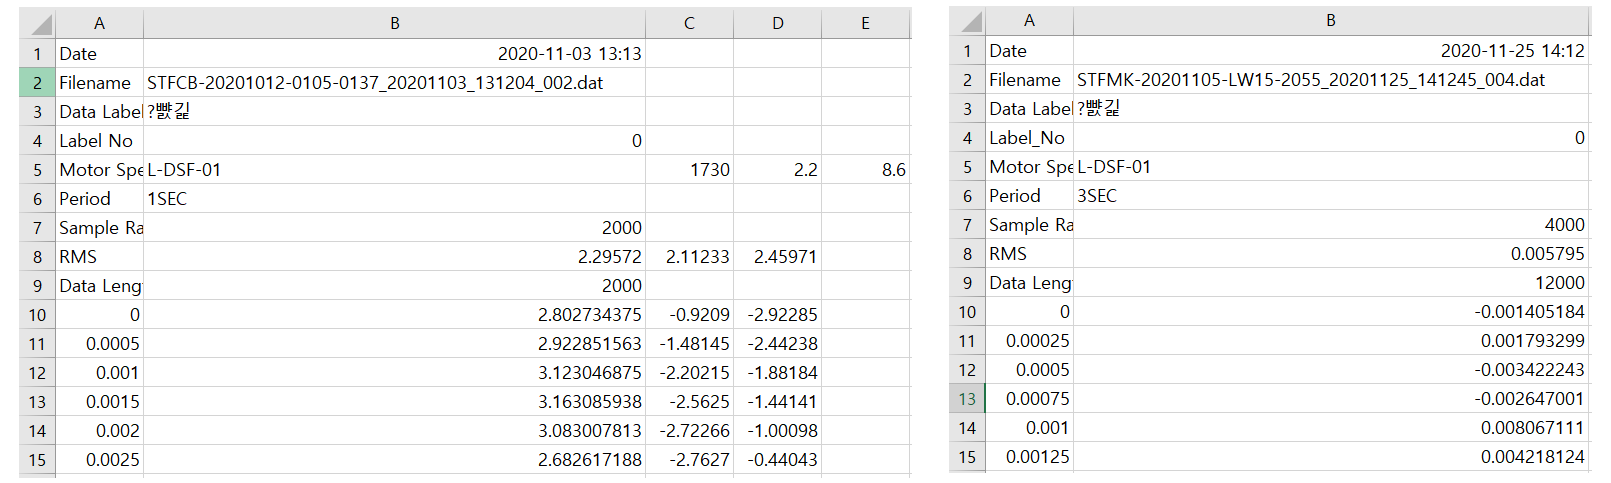

- df: 모든 csv파일 데이터를 담을 최종 data frame임
- - dfc: current
- - dfv: vibration
- i: 몇번째 저장 중인지 알려주는 인덱스임
- machine: 기계이름 가져옴
- types: 고장유형 가져옴
- files: 파일이름 가져옴
- tmp: csv파일 하나를 읽어와서 임시 저정하는 변수임, 9행까지는 skip함, 필요 없는 행 드롭함, 행열 뒤집음
- - dfc에서는 0열과 4열을 삭제
- - dfv에서는 0열과 2열을 삭제
- df: df에 tmp 결합함
- if: 실행확인을 위해 100 단위로 인덱스 출력함

In [ ]:
df=pd.DataFrame()
i=1 

for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    for files in os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types):
      tmp=pd.read_csv(file_path+'/current/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9)
      tmp=tmp.drop(['0','Unnamed: 4'],axis=1)
      tmp=tmp.transpose()
      df=pd.concat([df, tmp])
      if i%100==0: print(i, machine, types)
      i+=1

100 L-DSF-01 축정렬불량
200 L-DSF-01 축정렬불량
300 L-DSF-01 축정렬불량
400 L-DSF-01 정상
500 L-SF-04 정상
600 L-SF-04 베어링불량
700 L-SF-04 베어링불량
800 L-EF-04 회전체불평형
900 L-EF-04 회전체불평형
1000 L-EF-04 정상
1100 L-EF-04 정상
1200 L-EF-04 정상
1300 L-EF-04 정상
1400 L-EF-04 정상
1500 L-EF-04 정상
1600 L-EF-04 정상
1700 R-EF-05 벨트느슨함
1800 R-EF-05 벨트느슨함


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
3.04296875,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,-0.240234,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
-1.361328125,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,-2.322266,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
-2.7626953125,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,2.842773,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789
3.283203125,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,-2.242188,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
-2.8828125,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,-0.640625,...,2.842773,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.5224609375,1.961914,1.561523,1.000977,0.600586,0.040039,-0.640625,-1.321289,-1.641602,-2.082031,-2.602539,...,-0.480469,0.120117,0.600586,1.081055,1.521484,1.921875,2.322266,2.522461,2.562500,2.522461
-2.8828125,-3.042969,-3.083008,-3.002930,-2.882812,-2.762695,-2.602539,-1.961914,-1.561523,-1.081055,-0.600586,...,2.402344,1.961914,1.561523,1.201172,0.760742,0.280273,-0.280273,-0.800781,-1.241211,-1.601562
-2.6025390625,-2.242188,-1.921875,-1.561523,-1.121094,-0.600586,0.000000,0.640625,1.121094,1.561523,2.041992,...,-0.920898,-1.561523,-1.961914,-2.402344,-2.762695,-2.922852,-3.163086,-3.163086,-3.163086,-2.922852
2.162109375,2.402344,2.562500,2.682617,2.722656,2.522461,2.242188,1.921875,1.401367,1.081055,0.600586,...,-2.402344,-1.801758,-1.361328,-0.960938,-0.480469,0.240234,0.840820,1.521484,1.921875,2.242188


In [ ]:
df.to_csv('/content/gdrive/MyDrive/current.csv')

##
## df를 csv로 바꿔서 드라이브에 최종저장하는 것임!!! 한번만 실행!!!
##

## y데이터

- arr: 라벨 데이터를 담을 최종 array임
- mylist: 고장유형이랑 파일개수를 순서대로 저장하는 리스트임
- types: 아래의 오류 때문에 unicode 변환함
- - 오류: 한글이 같은데 == 결과가 false가 나옴, type은 str인데 1로 인덱싱 하니 첫글자가 아니라 자음이 나옴
- - 해결: https://jonsyou.tistory.com/26
- mylen
- for: step을 2로 해서 mylist에서 고장유형만 가져옴
- if: 고장유형이 정상이면 np.zeros()를 써서 0이 파일개수만큼 있는 array를 tmp에 저장함
- elif: 고장유형이 고장이면 np.ones()를 써서 1,2,3,4가 파일개수만큼 있는 array를 tmp에 저장함
-if: 첫번째면 arr에 tmp 대입함 (arr가 없기 때문에 아래 코드 쓰면 오류남)
-else: 아니면 arr에 tmp 이어붙이고 arr에 저장함

In [ ]:
mylist=[]
for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    types=unicodedata.normalize('NFC', types)
    mylen=len(os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types))
    mylist.append(str(types))
    mylist.append(mylen)

print(mylist)

['축정렬불량', 364, '정상', 97, '정상', 77, '베어링불량', 200, '회전체불평형', 229, '정상', 667, '벨트느슨함', 186, '정상', 65]


In [ ]:
for i in range(0,len(mylist),2):
  print(i, mylist[i])
  if mylist[i]=='정상': tmp=np.zeros(mylist[i+1])
  elif '베어링' in mylist[i]: tmp=np.ones(mylist[i+1])*1
  elif '벨트' in mylist[i]: tmp=np.ones(mylist[i+1])*2
  elif '축' in mylist[i]: tmp=np.ones(mylist[i+1])*3
  elif '회전체' in mylist[i]: tmp=np.ones(mylist[i+1])*4
  if i==0: arr=tmp
  else: arr=np.hstack([arr,tmp])

0 축정렬불량
2 정상
4 정상
6 베어링불량
8 회전체불평형
10 정상
12 벨트느슨함
14 정상


In [ ]:
arr[300:600]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

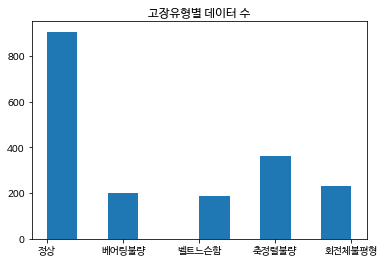

[906, 200, 186, 364, 229]

In [ ]:
plt.hist(list(arr))
plt.rc('font', family='NanumBarunGothic')
plt.title('고장유형별 데이터 수')
plt.xticks(range(5), ['정상','베어링불량','벨트느슨함','축정렬불량','회전체불평형'])
plt.show()

[list(arr).count(i) for i in range(5)]

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(df, arr, test_size=0.3, random_state=0)
